In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd
from omni import *
from mixup import * 


In [2]:
"""
Creates a MobileNetV3 Model as defined in:
Andrew Howard, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang, Yukun Zhu, Ruoming Pang, Vijay Vasudevan, Quoc V. Le, Hartwig Adam. (2019).
Searching for MobileNetV3
arXiv preprint arXiv:1905.02244.
"""

import torch.nn as nn
import math


__all__ = ['mobilenetv3_large', 'mobilenetv3_small']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size = 3, stride = stride,
                            padding = 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size = 1, stride = 1,
                            padding = 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )

def od_conv_1x1(inp, oup, kernel_num = 1):
    return nn.Sequential(
        # nn.Conv2d(inp, oup, kernel_size = 1, stride = 1,
        #                     padding = 0, bias=False), 
        ODConvBN(inp, oup, kernel_size = 1, 
                    stride = 1, kernel_num = kernel_num),
        h_swish()
    )

class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs, kernel_num = 4):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size, stride, groups=hidden_dim, kernel_num = 1),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1, kernel_num = kernel_num),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                ODConvBN(inp, hidden_dim, kernel_size = 1, stride = 1, kernel_num = 1),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                ODConvBN(hidden_dim, hidden_dim, kernel_size, stride, groups=hidden_dim, kernel_num = 1),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                ODConv2d(hidden_dim, oup, 1, 1, kernel_num = kernel_num),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV3(nn.Module):
    def __init__(self, cfgs, mode, num_classes=1000, width_mult=1.):
        super(MobileNetV3, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = cfgs
        assert mode in ['large', 'small']

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs, kernel_num = 4))
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        # self.conv = conv_1x1_bn(input_channel, exp_size)
        self.conv = od_conv_1x1(input_channel, exp_size, kernel_num = 4)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = {'large': 1280, 'small': 1024}

        output_channel = _make_divisible(output_channel[mode] * width_mult, 8) if width_mult > 1.0 else output_channel[mode]
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.conv(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()

    def net_update_temperature(self, temperature):
        for modules in self.modules():
            if hasattr(modules, "update_temperature"):
                modules.update_temperature(temperature)

    def display_temperature(self):
        for modules in self.modules():
            if hasattr(modules, "get_temperature"):
                return modules.get_temperature()

def mobilenetv3_large(**kwargs):
    """
    Constructs a MobileNetV3-Large model
    """
    cfgs = [
        # k, t,   c,  SE, HS, s
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
    ]
    return MobileNetV3(cfgs, mode='large', **kwargs)


def mobilenetv3_small(**kwargs):
    """
    Constructs a MobileNetV3-Small model
    """
    cfgs = [
        # k,   t,  c, SE, HS, s
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
    ]

    return MobileNetV3(cfgs, mode='small', **kwargs)


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [4]:
# from torchsummary import summary

# def show_model_summary(model, input_size):
#     print(summary(model, input_size=input_size))

# Training

In [5]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 77.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 83.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 52.3 MB/s eta 0:00:00


In [6]:
import torch
import torch.nn as nn
from torchvision import datasets

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from setup_data import *

Start downloading TinyImageNet
Extracting zip file: ./tiny-imagenet-200
Extracted at: /root/PlantDisease/tiny_imagenet/images
Formatting: /root/PlantDisease/tiny_imagenet/images/tiny-imagenet-200/val
Cleaning up /root/PlantDisease/tiny_imagenet/images/tiny-imagenet-200/val/images
Formatting val done


In [7]:
from argparse import Namespace

args = Namespace(
    train_dir = './images/tiny-imagenet-200/train/',
    val_dir = './images/tiny-imagenet-200/val',
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    batch_size = 128,
    num_workers = 4
)

[109, 45, 122, 28, 40, 0, 1, 2, 3, 4]
10


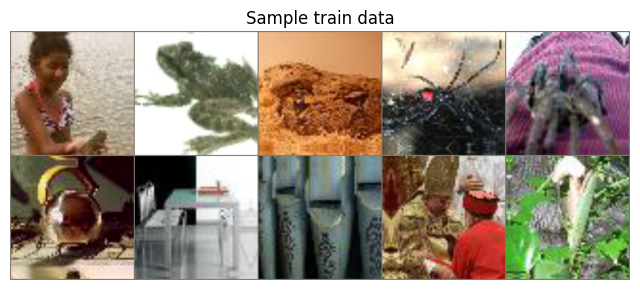

In [8]:
data = TinyImageNet(args)
data.show_samples()

In [9]:
classes_labels = data.data_labels

train_loader = data.train_loader
test_loader = data.test_loader

In [10]:
import logging
import os
from tqdm.notebook import tqdm

def check_logging_directory(path):
  parent_directory = os.path.dirname(path)
  if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)
    print("Create new directory")

logging_path = './logging/mixup_mobilenetv3_omni_tinyimagenet_modified_afternoon.log'
check_logging_directory(logging_path)

logging.basicConfig(filename=logging_path, level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [11]:
import torch.optim as optim

num_epochs = 100
learning_rate = 0.05

mb_v3 =  mobilenetv3_small(num_classes = 200).to(args.device)
criterion = nn.CrossEntropyLoss().to(args.device)
optimizer = torch.optim.SGD(mb_v3.parameters(), lr=learning_rate, 
                            weight_decay=0.00004, momentum = 0.9)

print(f"The number of parameters: {count_parameters(mb_v3)}")

The number of parameters: 2770269


In [12]:
# show_model_summary(mb_v3, (3, 224, 224))

In [13]:
def adjust_learning_rate(optimizer, epoch, total_epochs, iteration, iter_per_epoch, initial_lr = 0.05):
    current_iter = iteration + epoch * iter_per_epoch
    max_iter = total_epochs * iter_per_epoch

    lr = initial_lr * (1 + np.cos(np.pi * current_iter / max_iter)) / 2

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

def get_temperature(iteration, epoch, iter_per_epoch, temp_epoch=10, temp_init=30.0):
    total_temp_iter = iter_per_epoch * temp_epoch
    current_iter = iteration + epoch * iter_per_epoch
    # print(current_iter)
    temperature = 1.0 + max(0, (temp_init - 1.0) * ((total_temp_iter - current_iter) / total_temp_iter))
    return temperature

In [ ]:
# Huấn luyện mô hình
train_loss, val_loss = [], []
train_acc, val_acc = [], []

epoch_bar = tqdm(desc = 'Epoch',
                 total = num_epochs, position = 1)
train_bar = tqdm(desc = 'Training', total = len(train_loader),
                 position = 1, leave = True)
val_bar = tqdm(desc = 'Validation', total = len(test_loader),
               position = 1, leave = True)

print("🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀")
logging.info("🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀")

for epoch in range(num_epochs):

    epoch_bar.set_description(f'Epoch {epoch + 1}/{num_epochs}')

    mb_v3.train()
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    for i, (X, y) in enumerate(train_loader):

        if epoch < 50:
            temp = get_temperature(i + 1, epoch, len(train_loader), temp_epoch = 50, temp_init = 60.0)
            mb_v3.net_update_temperature(temp)
            # print(f"The temperature is: {temp}")

        optimizer.zero_grad()
        X, y = X.to(args.device), y.to(args.device)

        X, y_origin, y_sampled, lam = mixup_data(X, y, args.device, alpha = 0.4)
 
        # Forward pass
        output = mb_v3(X)
        loss = criterion(output, y)
        loss = mixup_criterion(criterion, output, y_origin, y_sampled, lam)
        
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (i + 1)
        total_loss += loss_t

        # Backward pass
        loss.backward()
        optimizer.step()

        temp_lr = adjust_learning_rate(optimizer, epoch, num_epochs,
                                       i + 1, len(train_loader), initial_lr = learning_rate)
        
        # Calculating the accuracy
        _, predicted = torch.max(output.data, 1)
        n_correct = (lam * predicted.eq(y_origin.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(y_sampled.data).cpu().sum().float())

        acc_t = n_correct / len(predicted) * 100
        running_acc += (acc_t - running_acc) / (i + 1)

        total_acc += n_correct
        total += y.shape[0]


        train_bar.set_postfix(loss = running_loss,
                              acc = f"{running_acc:.2f}%",
                              epoch = epoch + 1)
        train_bar.update()

    current_loss = total_loss / len(train_loader)
    current_acc = total_acc / total * 100
    train_loss.append(current_loss)
    train_acc.append(current_acc)

    print("========================================")
    print("\033[1;34m" + f"Epoch {epoch + 1}/{num_epochs}" + "\033[0m")
    print(f"Train Loss: {current_loss:.2f}\t|\tTrain Acc: {current_acc:.2f}%")

    logging.info("========================================")
    logging.info(f"Epoch {epoch + 1}/{num_epochs}")
    logging.info(f"Train Loss: {current_loss:.2f}  -   Train Acc: {current_acc:.2f}%")


    # Eval trên valid set
    running_loss = 0.0
    running_acc = 0.0
    total_loss = 0.0
    total_acc = 0.0

    total = 0
    mb_v3.eval()
    with torch.no_grad():
        for i, (X, y) in enumerate(test_loader):

            X, y = X.to(args.device), y.to(args.device)
            # Forward pass
            output = mb_v3(X)

            # Calculate Loss
            loss = criterion(output, y)
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (i + 1)
            total_loss += loss_t

            # Calculate Accuracies
            _, predicted = torch.max(output.data, 1)
            n_correct = (predicted == y).sum().item()
            acc_t = n_correct / len(predicted) * 100
            running_acc += (acc_t - running_acc) / (i + 1)
            total_acc += n_correct

            total += y.shape[0]

            val_bar.set_postfix(loss = running_loss,
                                acc = f"{running_acc:.2f}%",
                                epoch = epoch + 1)
            val_bar.update()

    current_loss = total_loss / len(test_loader)
    current_acc = total_acc / total * 100

    val_loss.append(current_loss)
    val_acc.append(current_acc)

    print(f"Val Loss: {current_loss:.2f}\t|\tVal Acc: {current_acc:.2f}%")
    logging.info(f"Val Loss: {current_loss:.2f}  -  Val Acc: {current_acc:.2f}%")

    train_bar.n = 0
    val_bar.n = 0
    epoch_bar.update()

    if epoch < 50:
        temperature = mb_v3.display_temperature()
        print(f"The current temperature is: {temperature}")

    print(f"The current learning rate is: {temp_lr}")


print("========================================")
print("Training Completed! 😀")
logging.info("========================================")
logging.info("Training Completed! 😀")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/782 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

🚀 Training MobileNetV3 - Omni Dimensional Dynamic Convolution 🚀
Epoch 1/100
Train Loss: 4.93	|	Train Acc: 3.26%
Val Loss: 4.51	|	Val Acc: 6.45%
The current temperature is: 58.82
The current learning rate is: 0.04998766400914329
Epoch 2/100
Train Loss: 4.38	|	Train Acc: 9.74%
Val Loss: 3.86	|	Val Acc: 14.25%
The current temperature is: 57.64
The current learning rate is: 0.04995066821070679
Epoch 3/100
Train Loss: 4.09	|	Train Acc: 14.67%
Val Loss: 3.58	|	Val Acc: 18.66%
The current temperature is: 56.459999999999994
The current learning rate is: 0.049889049115077
Epoch 4/100
Train Loss: 3.91	|	Train Acc: 18.49%
Val Loss: 3.51	|	Val Acc: 21.25%
The current temperature is: 55.28
The current learning rate is: 0.04980286753286195
Epoch 5/100
Train Loss: 3.72	|	Train Acc: 21.76%
Val Loss: 3.12	|	Val Acc: 29.18%
The current temperature is: 54.1
The current learning rate is: 0.04969220851487845
Epoch 6/100
Train Loss: 3.60	|	Train Acc: 24.47%
Val Loss: 2.86	|	Val Acc: 33.26%
The current tempe

In [ ]:
len(val_loss)

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

if not os.path.exists("./plot"):
    os.makedirs("./plot")
    print("Creating a new directory")

def plot_loss(train_loss, val_loss, loss_fig):
    plt.figure(figsize = (10, 6))
    plt.plot(range(num_epochs), train_loss)
    plt.plot(range(num_epochs), val_loss)

    plt.xlabel("Num Epochs")
    plt.ylabel("Loss Value")
    
    plt.savefig(loss_fig)
    plt.show()

def plot_accuracy(train_acc, val_acc, acc_fig):
    plt.figure(figsize = (10, 6))
    plt.plot(range(num_epochs), train_acc)
    plt.plot(range(num_epochs), val_acc)

    plt.xlabel("Num Epochs")
    plt.ylabel("Accuracy (%)")
    
    plt.savefig(acc_fig)
    plt.show()

loss_path = "./plot/loss_fig_omni_tinyimagenet_modified.png"
acc_path = "./plot/acc_fig_omni_tinyimagenet_modified.png"

plot_loss(train_loss, val_loss, loss_path)
plot_accuracy(train_acc, val_acc, acc_path)


In [ ]:
train_lowest_loss = np.argmin(train_loss)
train_highest_acc = np.argmax(train_acc)
print(f"The index of lowest train loss: {train_lowest_loss + 1}")
print(f"Train Loss: {train_loss[train_lowest_loss]}")
print(f"The index of highest train accuracy: {train_highest_acc + 1}")
print(f"Train Loss: {train_acc[train_highest_acc]}")

In [ ]:
val_lowest_loss = np.argmin(val_loss)
val_highest_acc = np.argmax(val_acc)
print(f"The index of lowest train loss: {val_lowest_loss + 1}")
print(f"Train Loss: {val_loss[val_lowest_loss]}")
print(f"The index of highest train accuracy: {val_highest_acc + 1}")
print(f"Train Loss: {val_acc[val_highest_acc]}")